# Likelihood Functions and Confidence Intervals
by Alex Drlica-Wagner

## Introduction

This notebook attempts to pragmatically address several questions about deriving uncertainty intervals from a likelihood analysis.

In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn
try:
    import emcee
    got_emcee = True
except ImportError:
    got_emcee = False

try:
    import corner
    got_corner = True
except ImportError:
    got_corner = False

plt.rcParams['axes.labelsize'] = 16

## 1D Likelihood

As a simple and straightforward starting example, we begin with a 1D Gaussian likelihood function.

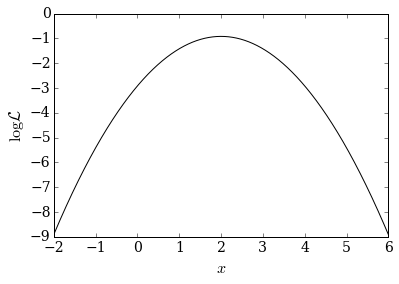

In [2]:
mean = 2.0; cov = 1.0
rv = mvn(mean,cov)
lnlfn = lambda x: rv.logpdf(x)
x = np.linspace(-2,6,5000)
lnlike = lnlfn(x)

plt.plot(x,lnlike,'-k'); plt.xlabel(r'$x$'); plt.ylabel('$\log \mathcal{L}$');

For this simple likelihood function, we could analytically compute the maximum likelihood estimate and confidence intervals. However, for more complicated likelihoods an analytic solution may not be possible. As an introduction to these cases it is informative to proceed numerically.

In [3]:
# You can use any complicate optimizer that you want (i.e. scipy.optimize) 
# but for this application we just do a simple array operation
maxlike = np.max(lnlike)
mle = x[np.argmax(lnlike)]
print "Maximum Likelihood Estimate: %.2f"%mle 
print "Maximum Likelihood Value: %.2f"%maxlike

Maximum Likelihood Estimate: 2.00
Maximum Likelihood Value: -0.92


To find the 68% confidence intervals, we can calculate the delta-log-likelihood. The test statisitcs (TS) is defined as ${\rm TS} = -2\Delta \log \mathcal{L}$ and is $\chi^2$-distributed. Therefore, the confidence intervals on a single parameter can be read off of a $\chi^2$ table with 1 degree of freedom (dof).


| 2-sided Interval | p-value | $\chi^2_{1}$ | Gaussian $\sigma$ |
|------|------|------|------|
| 68% | 32%  | 1.000 | 1.00 |
| 90% | 10%  | 2.706 | 1.64 |
| 95% | 5%  | 3.841 | 1.96 |
| 99% | 1%  | 6.635 | 2.05 |


Confidence Intervals:
  68% CL: x = 2.00 [-1.00,+1.00]
  90% CL: x = 2.00 [-1.64,+1.65]
  95% CL: x = 2.00 [-1.96,+1.96]


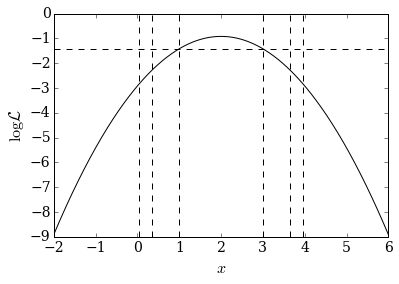

In [4]:
def interval(x, lnlike, delta=1.0):
    maxlike = np.max(lnlike)
    ts = -2 * (lnlike - maxlike)
    lower = x[np.argmax(ts < delta)]
    upper = x[len(ts) - np.argmax((ts < delta)[::-1]) - 1]
    return lower, upper

intervals = [(68,1.0),
             (90,2.706),
             (95,3.841)]

plt.plot(x,lnlike,'-k'); plt.xlabel(r'$x$'); plt.ylabel('$\log \mathcal{L}$');
kwargs = dict(ls='--',color='k')
plt.axhline(maxlike - intervals[0][1]/2.,**kwargs)
print "Confidence Intervals:"
for cl,delta in intervals:
    lower,upper = interval(x,lnlike,delta)
    print "  %i%% CL: x = %.2f [%+.2f,%+.2f]"%(cl,mle,lower-mle,upper-mle)
    plt.axvline(lower,**kwargs); plt.axvline(upper,**kwargs); 


These numbers might look familiar. They are the number of standard deviations that you need to go out in the standard normal distribution to contain the requested fraction of the distribution (i.e., 68%, 90%, 95%).

In [5]:
for cl, d in intervals:
    sigma = stats.norm.isf((100.-cl)/2./100.)
    print "  %i%% = %.2f sigma"%(cl,sigma)

  68% = 0.99 sigma
  90% = 1.64 sigma
  95% = 1.96 sigma


## 2D Likelihood

Now we extend the example above to a 2D likelihood function. We define the likelihood with the same ```multivariat_normal``` function, but now add a second dimension and a covariance between the two dimensions. These parameters are adjustable if would like to play around with them.

In [6]:
mean = [2.0,1.0]
cov = [[1,1],[1,2]]
rv = stats.multivariate_normal(mean,cov)
lnlfn = lambda x: rv.logpdf(x)

print "Mean:",rv.mean.tolist()
print "Covariance",rv.cov.tolist()

Mean: [2.0, 1.0]
Covariance [[1.0, 1.0], [1.0, 2.0]]


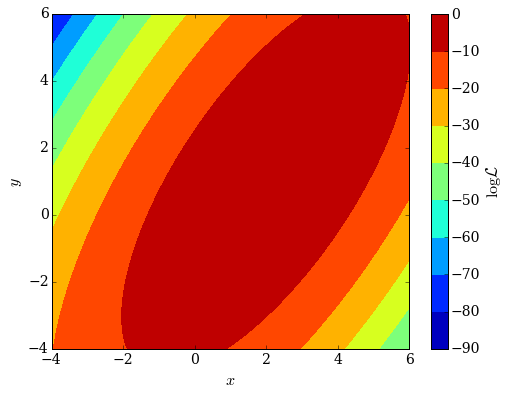

In [7]:
xx, yy = np.mgrid[-4:6:.01, -4:6:.01]
values = np.dstack((xx, yy))
lnlike = lnlfn(values)

fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)
im = ax2.contourf(values[:,:,0], values[:,:,1], lnlike ,aspect='auto'); plt.colorbar(im,label='$\log \mathcal{L}$')
plt.xlabel('$x$'); plt.ylabel('$y$');
plt.show()

In [8]:
# You can use any complicate optimizer that you want (i.e. scipy.optimize) 
# but for this application we just do a simple array operation
maxlike = np.max(lnlike)
maxidx = np.unravel_index(np.argmax(lnlike),lnlike.shape)
mle_x, mle_y = mle = values[maxidx]

print "Maximum Likelihood Estimate:",mle 
print "Maximum Likelihood Value:",maxlike

Maximum Likelihood Estimate: [ 2.  1.]
Maximum Likelihood Value: -1.83787706641


The case now becomes a bit more complicated. If you want to set a confidence interval on a single parameter, you cannot simply projected the likelihood onto the dimension of interest. Doing so would ignore the correlation between the two parameters.

Projected Likelihood (red):	 2.0 [-1.16,+1.16]
Profile Likelihood (black):	 2.0 [-1.64,+1.64]


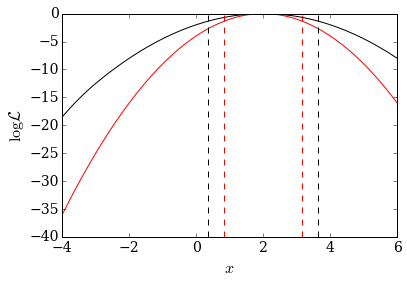

In [9]:
lnlike -= maxlike
x = xx[:,maxidx[1]]
delta = 2.706

# This is the loglike projected at y = mle[1] = 0.25
plt.plot(x, lnlike[:,maxidx[1]],'-r'); 
lower,upper = max_lower,max_upper = interval(x,lnlike[:,maxidx[1]],delta)
plt.axvline(lower,ls='--',c='r'); plt.axvline(upper,ls='--',c='r')
y_max = yy[:,maxidx[1]]

# This is the profile likelihood where we maximize over the y-dimension
plt.plot(x, lnlike.max(axis=1),'-k')
lower,upper = profile_lower,profile_upper = interval(x,lnlike.max(axis=1),delta)
plt.axvline(lower,ls='--',c='k'); plt.axvline(upper,ls='--',c='k')
plt.xlabel('$x$'); plt.ylabel('$\log \mathcal{L}$')
y_profile = yy[lnlike.argmax(axis=0),lnlike.argmax(axis=1)]

print "Projected Likelihood (red):\t %.1f [%+.2f,%+.2f]"%(mle[0],max_lower-mle[0],max_upper-mle[0])
print "Profile Likelihood (black):\t %.1f [%+.2f,%+.2f]"%(mle[0],profile_lower-mle[0],profile_upper-mle[0])

In the plot above we are showing two different 1D projections of the 2D likelihood function. The red curve shows the projected likelihood scanning in values of $x$ and always assuming the value of $y$ that maximized the likelihood. On the other hand, the black curve shows the 1D likelihood derived by scanning in values of $x$ and at each value of $x$ maximizing the value of the likelihood with respect to the $y$-parameter. In other words, the red curve is ignoring the correlation between the two parameters while the black curve is accounting for it. As you can see from the values printed above the plot, the intervals derived from the red curve understimate the analytically derived values, while the intervals on the black curve properly reproduce the analytic estimate.

Just to verify the result quoted above, we derive intervals on $x$ at several different confidence levels. We start with the projected likelihood with $y$ fixed at $y_{\rm max}$.

In [10]:
for cl, d in intervals: 
    lower,upper = interval(x,lnlike[:,maxidx[1]],d)
    print "  %s CL: x = %.2f [%+.2f,%+.2f]"%(cl,mle[0],lower-mle[0],upper-mle[0])

  68 CL: x = 2.00 [-0.70,+0.70]
  90 CL: x = 2.00 [-1.16,+1.16]
  95 CL: x = 2.00 [-1.38,+1.38]


Below are the confidence intervals in $x$ derived from the profile likelihood technique. As you can see, these values match the analytically derived values.

In [11]:
for cl, d in intervals: 
    lower,upper = interval(x,lnlike.max(axis=1),d)
    print "  %s CL: x = %.2f [%+.2f,%+.2f]"%(cl,mle[0],lower-mle[0],upper-mle[0])

  68 CL: x = 2.00 [-0.99,+0.99]
  90 CL: x = 2.00 [-1.64,+1.64]
  95 CL: x = 2.00 [-1.95,+1.95]


By plotting the likelihood contours, it is easy to see why the profile likelihood technique performs correctly while naively slicing through the likelihood plane does not. The profile likelihood is essentially tracing the ridgeline of the 2D likelihood function, thus intersecting the countour of delta-log-likelihood at it's most distant point. This can be seen from the black lines in the 2D likelihood plot below.

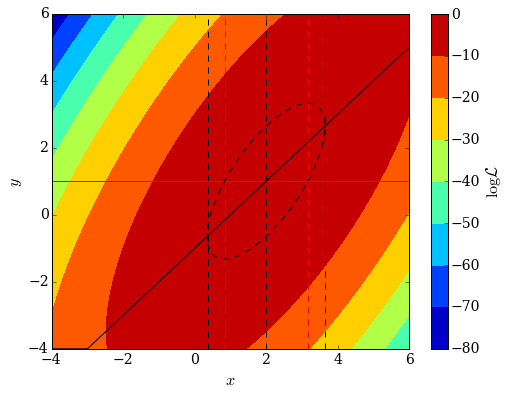

In [12]:
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)
im = ax2.contourf(values[:,:,0], values[:,:,1], lnlike ,aspect='auto'); plt.colorbar(im,label='$\log \mathcal{L}$')
im = ax2.contour(values[:,:,0], values[:,:,1], lnlike , levels=[-delta/2], colors=['k'], aspect='auto', zorder=10,lw=2);

plt.axvline(mle[0],ls='--',c='k'); plt.axhline(mle[1],ls='--',c='k');
plt.axvline(max_lower,ls='--',c='r'); plt.axvline(max_upper,ls='--',c='r')
plt.axvline(profile_lower,ls='--',c='k'); plt.axvline(profile_upper,ls='--',c='k')

plt.plot(x,y_max,'-r'); plt.plot(x,y_profile,'-k')
plt.xlabel('$x$'); plt.ylabel('$y$');
plt.show()

## MCMC Posterior Sampling

One way to explore the posterior distribution is through MCMC sampling. This gives an alternative method for deriving confidence intervals. Now, rather than maximizing the likelihood as a function of the other parameter, we marginalize (integrate) over that parameter. This is more computationally intensive, but is more robust in the case of complex likelihood functions.

In [13]:
# Remember, the posterior probability is the likelihood times the prior
lnprior = lambda x: 0
def lnprob(x):
    return lnlfn(x) + lnprior(x)

if got_emcee:
    nwalkers=100
    ndim, nwalkers = len(mle), 100
    pos0 = [np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=2)
    # This takes a while...
    sampler.run_mcmc(pos0, 5000)


In [14]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
x_samples,y_samples = samples.T

for cl in [68,90,95]:
    x_lower,x_mle,x_upper = np.percentile(x_samples,q=[(100-cl)/2.,50,100-(100-cl)/2.])
    print "  %i%% CL:"%cl, "x = %.2f [%+.2f,%+.2f]"%(x_mle,x_lower-x_mle,x_upper-x_mle)


  68% CL: x = 2.00 [-0.98,+1.00]
  90% CL: x = 2.00 [-1.64,+1.65]
  95% CL: x = 2.00 [-1.96,+1.96]


These results aren't perfect since they are suspect to random variations in the sampling, but they are pretty close. Plotting the distribution of samples, we see something very similar to the plots we generated for the likelihood alone (which is good since out prior was flat).

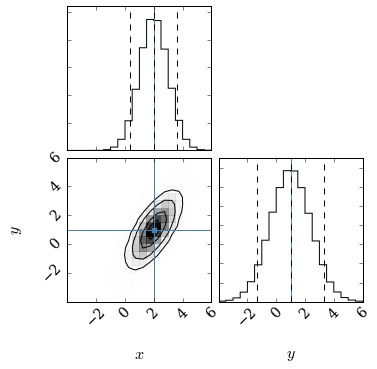

In [15]:
if got_corner:
    fig = corner.corner(samples, labels=["$x$","$y$"],truths=mle,quantiles=[0.05, 0.5, 0.95],range=[[-4,6],[-4,6]])
    